## Running notebook to test the developed functions

In [1184]:
import matplotlib.pyplot as plt
import cv2

%load_ext autoreload
%autoreload 2

from src import preprocessing as pp
from src import contour_detection as cd
from src import symetry_analysis as sa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1185]:
image_path = "data/example1.jpg"

Size:  (267, 244, 3)


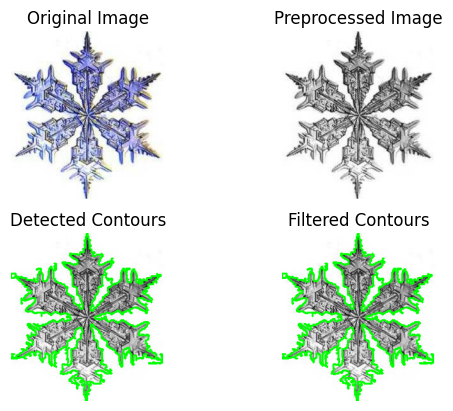

In [1186]:
image = cv2.imread(image_path)
preprocessed_image = pp.preprocess_image(image)
contour_image, contours = cd.detect_contours(preprocessed_image)
filtered_contour_image, filtered_contours = cd.filter_contours(preprocessed_image, contours, min_area=100, max_area=10000)#, circularity_threshold=0.01)

print("Size: ", image.shape)

plt.subplot(2, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Preprocessed Image")
plt.imshow(preprocessed_image, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title("Detected Contours")
plt.imshow(contour_image)
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Filtered Contours")
plt.imshow(cv2.cvtColor(filtered_contour_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

Axis Ratio: 0.9119
Circle/Rectangle Ratio: 0.7744
Average Rotational Symmetry: 0.7804
Final Symmetry Score: 0.8222


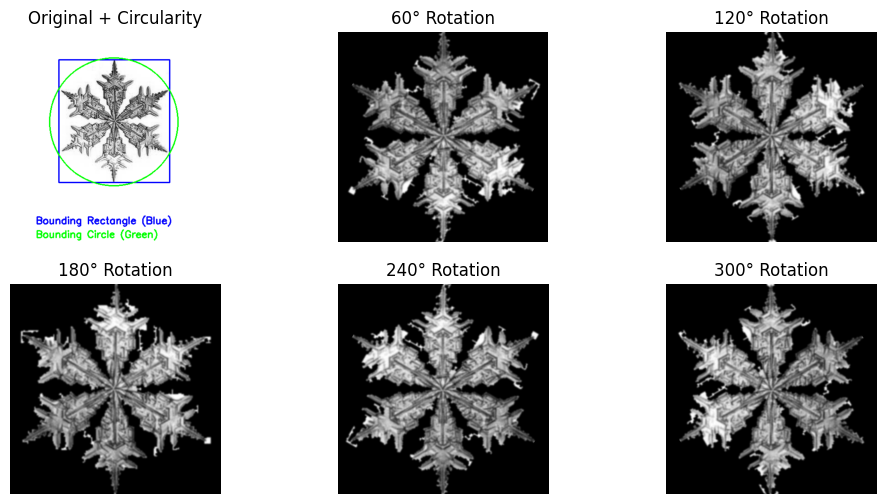

In [1187]:
score = sa.analyze_symmetry(preprocessed_image, filtered_contours, vis=True)